# Práctica 5 — Ajedrez

In [88]:
import matplotlib.pyplot as plt
import pandas as pd
import dask.dataframe as dd
import numpy as np
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.utils import shuffle

In [89]:
# Cargamos subconjunto del dataset
df = pd.read_csv('lichess_games.csv', nrows=10000)

# 2. Eliminamos columnas innecesarias
df = df.drop(columns=['Site', 'White', 'Black', 'Opening'])

# 3. Preprocesamiento de Elo (asumir "?" como 0)
df['WhiteElo'] = pd.to_numeric(df['WhiteElo'].replace('?', '0'))
df['BlackElo'] = pd.to_numeric(df['BlackElo'].replace('?', '0'))

# Añadimos atributos derivados
df['GameElo'] = np.ceil((df['WhiteElo'] + df['BlackElo']) / 2)
df['EloDiff'] = df['WhiteElo'] - df['BlackElo']

# 4. Codificación de variables categóricas
le = LabelEncoder()
columnas_a_codificar = ['Result', 'TimeControl', 'ECO', 'Termination']
for col in columnas_a_codificar:
    df[col] = le.fit_transform(df[col].astype(str))

original = df.copy()

y = original['Result'].values
X = original.drop(columns=['Result']).values

print(original.head(5))
print(X.shape, y.shape)

   Result  WhiteElo  BlackElo  TimeControl  ECO  Termination  MovesCount  \
0       2      1247      1218           17  152            1          15   
1       1      1577      1593           17   75            2          52   
2       2      1043      1000           17  204            1          44   
3       2      2015      2028           17   76            1          29   
4       1      2139      2145           17   73            1          56   

   GameElo  EloDiff  
0   1233.0       29  
1   1585.0      -16  
2   1022.0       43  
3   2022.0      -13  
4   2142.0       -6  
(10000, 8) (10000,)


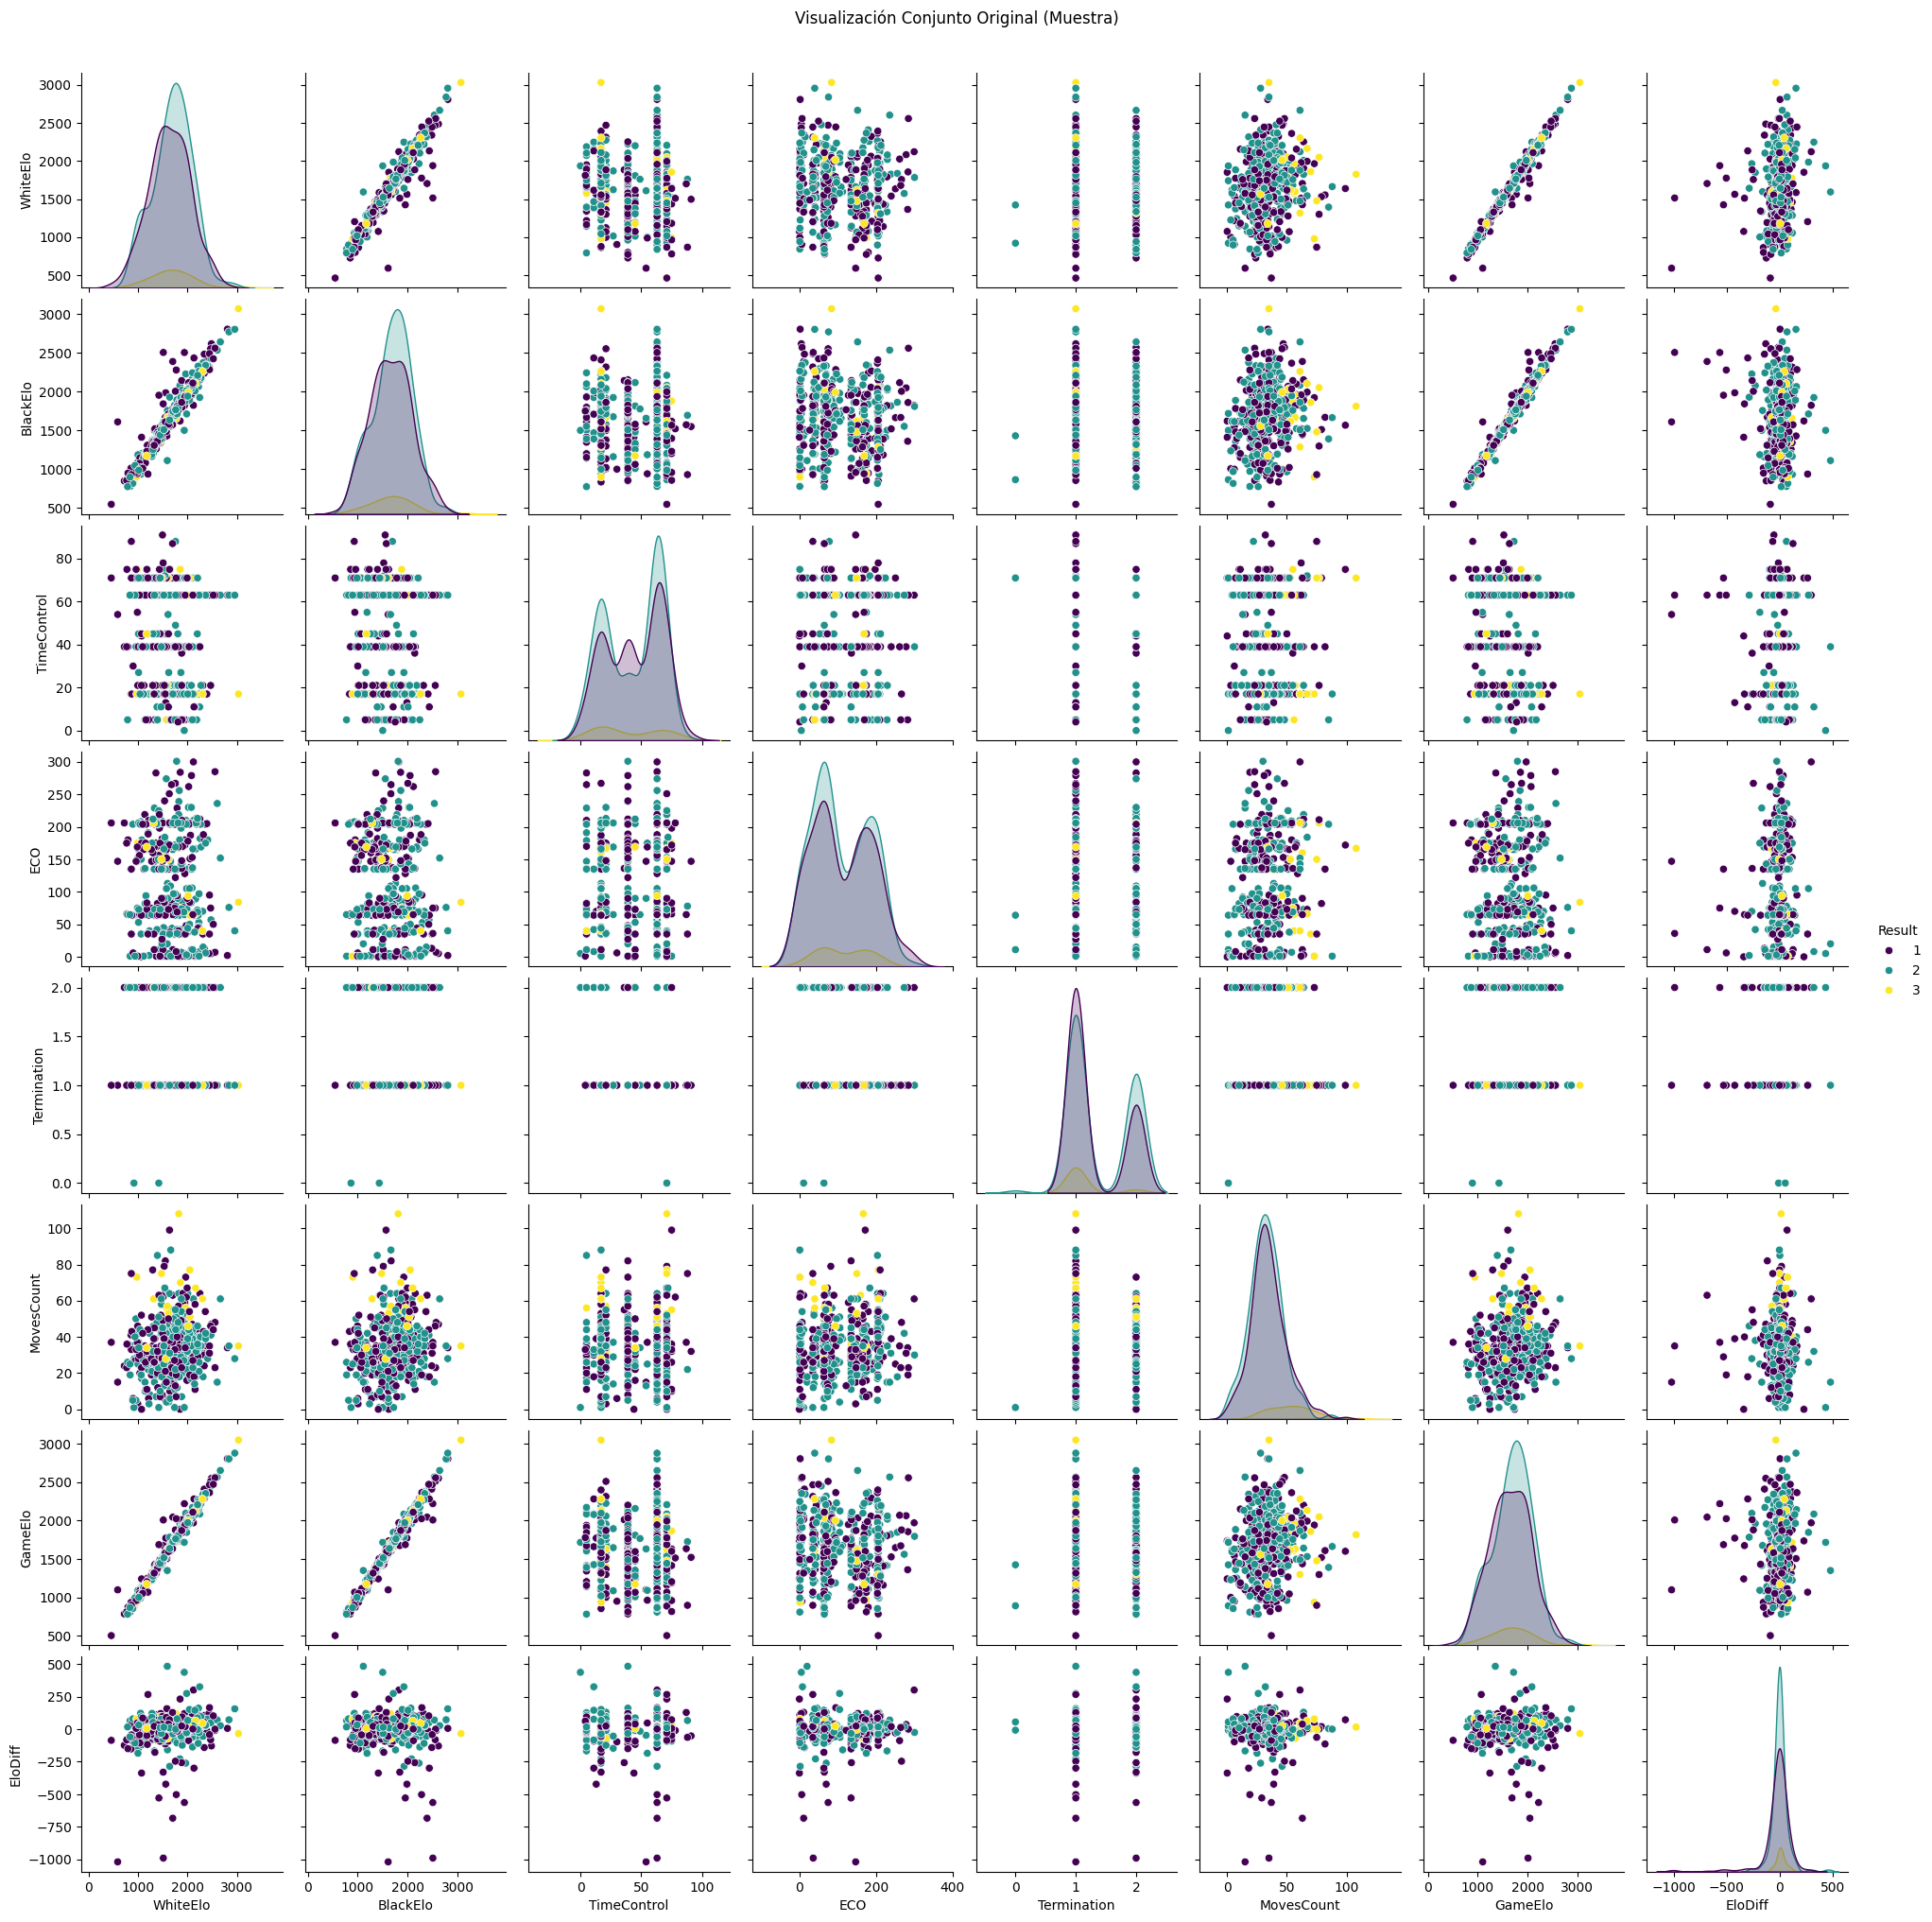

In [90]:
# Tomamos una muestra para no ralentizar el gráfico
sns.pairplot(original.sample(500), hue='Result', palette='viridis')
plt.suptitle("Visualización Conjunto Original (Muestra)", y=1.02)
plt.show()

In [91]:
# Obtenemos el conjunto de datos estandarizado
standarized = StandardScaler().fit_transform(original)

#standarized = pd.DataFrame(standarized, columns=original.columns)
#standarized.plot.scatter(x='WhiteElo', y='BlackElo', c=y, cmap='viridis', alpha=0.5)

In [92]:
normalized = MinMaxScaler().fit_transform(original)

#normalized = pd.DataFrame(normalized, columns=original.columns)
#normalized.plot.scatter(x='WhiteElo', y='BlackElo', c=y, cmap='viridis', alpha=0.5)

In [99]:
def mostrar_pca(pca, pca_data, y, ax, title=""):
    if pca_data.shape[1] == 1: 
        ax.set_title(title + f"\nVarianza: {pca.explained_variance_ratio_[0]*100:.2f}%")
        ax.scatter(pca_data[:, 0], np.zeros(pca_data.shape[0]), c=y, cmap=plt.cm.Set1, edgecolor="k")
        ax.set_xlabel("Componente principal 1")

    elif pca_data.shape[1] == 2:
        total_var = (pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1]) * 100
        ax.set_title(title + f"\nVarianza total: {total_var:.2f}%")
        ax.scatter(pca_data[:, 0], pca_data[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
        ax.set_xlabel("Componente 1")
        ax.set_ylabel("Componente 2")
    else:
        print(f"PCA con {pca_data.shape[1]} componentes, no se puede graficar en 2D.")
        ax.text(0.5, 0.5, "Más de 2 componentes", ha='center', va='center')

PCA con 7 componentes, no se puede graficar en 2D.
PCA con 5 componentes, no se puede graficar en 2D.
PCA con 5 componentes, no se puede graficar en 2D.
PCA con 4 componentes, no se puede graficar en 2D.


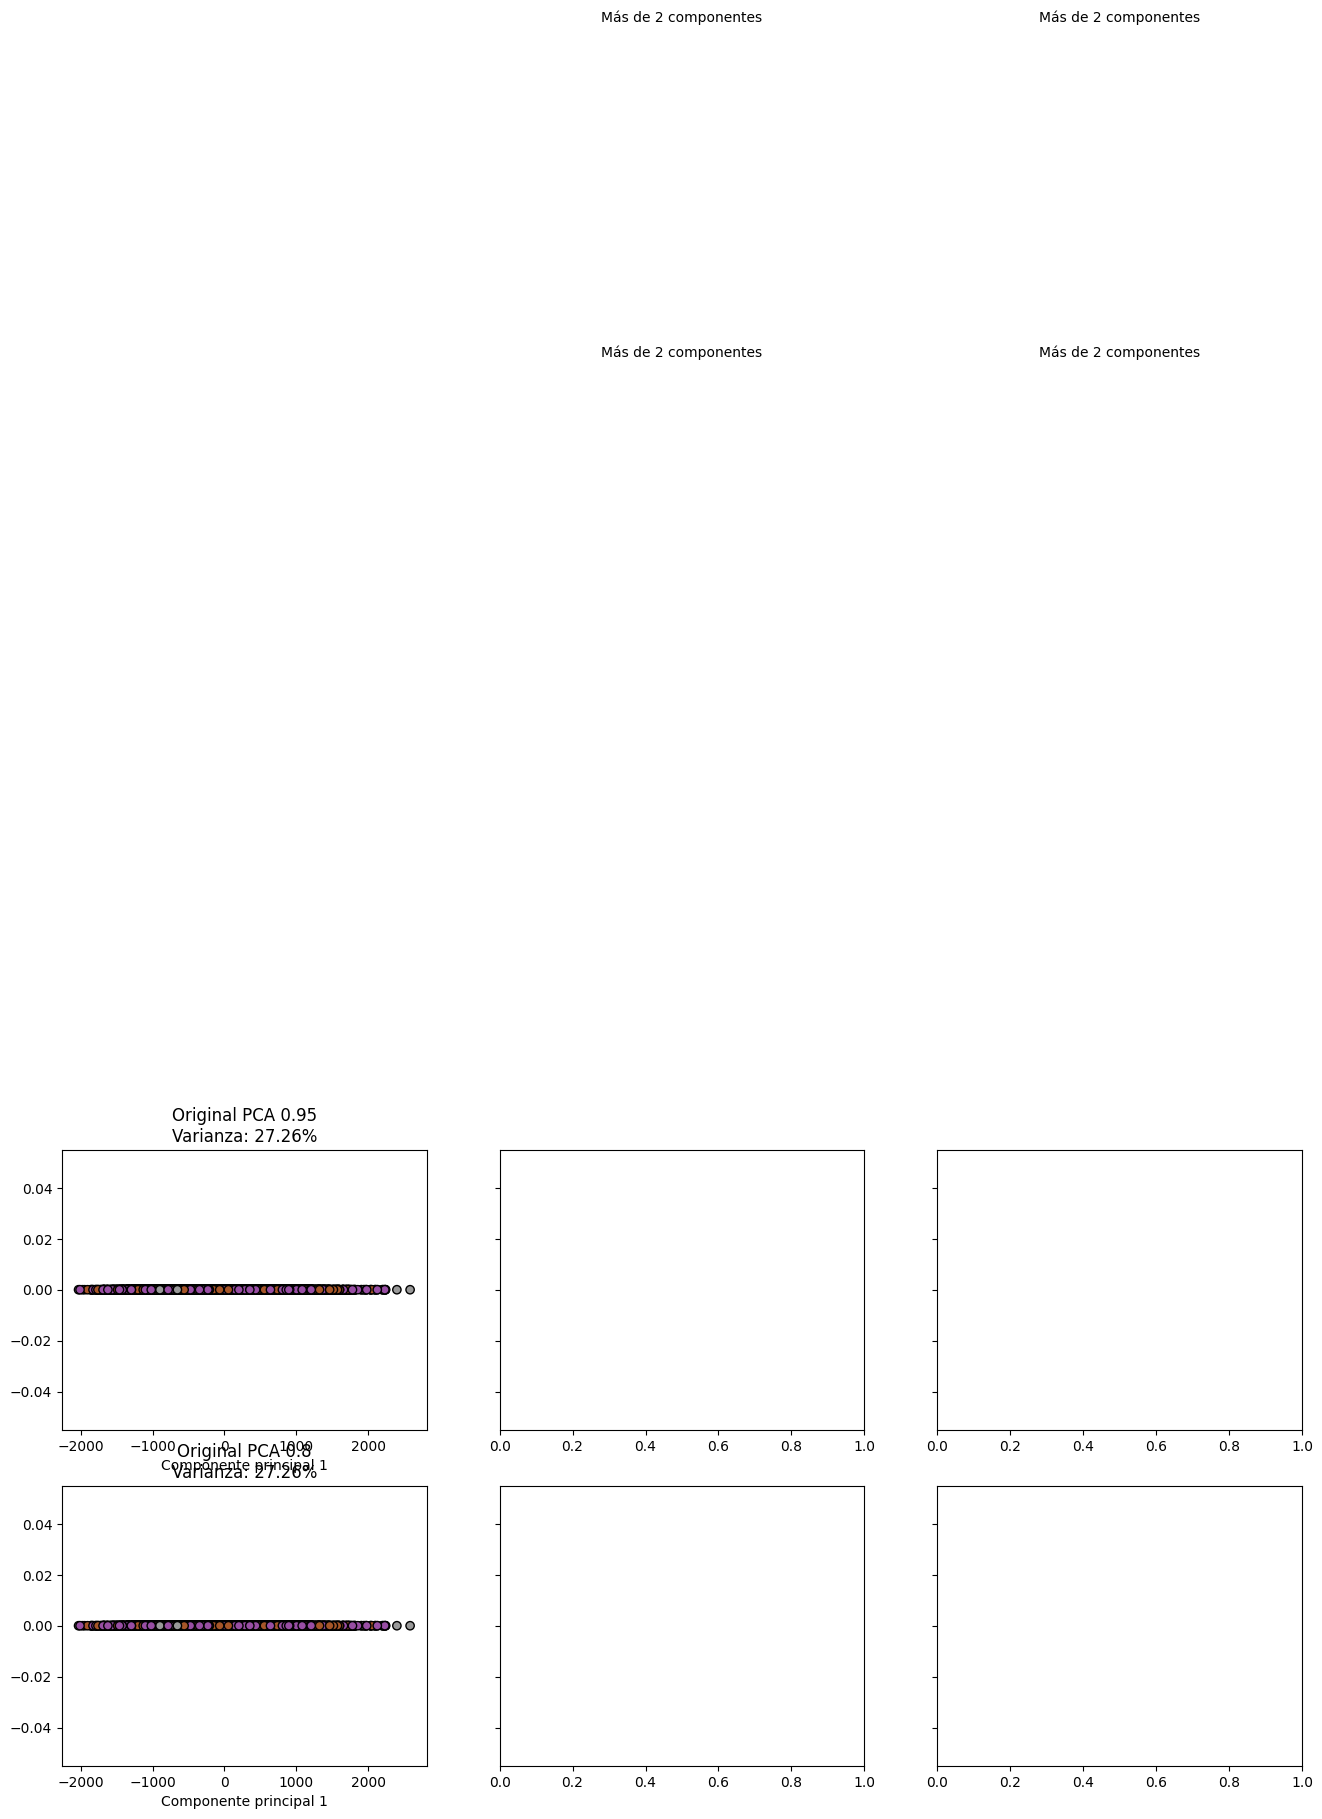

In [100]:
pca95 = PCA(n_components=0.95)
pca80 = PCA(n_components=0.8)

# Creamos una sola figura con 6 subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8), sharey=True)

# PCA 0.95
original_pca95 = pca95.fit_transform(original)
standarized_pca95 = pca95.fit_transform(standarized)
normalized_pca95 = pca95.fit_transform(normalized)

mostrar_pca(pca95, original_pca95, y, axes[0, 0], "Original PCA 0.95")
mostrar_pca(pca95, standarized_pca95, y, axes[0, 1], "Estandarizado PCA 0.95")
mostrar_pca(pca95, normalized_pca95, y, axes[0, 2], "Normalizado PCA 0.95")

# PCA 0.8
original_pca80 = pca80.fit_transform(original)
standarized_pca80 = pca80.fit_transform(standarized)
normalized_pca80 = pca80.fit_transform(normalized)

mostrar_pca(pca80, original_pca80, y, axes[1, 0], "Original PCA 0.8")
mostrar_pca(pca80, standarized_pca80, y, axes[1, 1], "Estandarizado PCA 0.8")
mostrar_pca(pca80, normalized_pca80, y, axes[1, 2], "Normalizado PCA 0.8")

plt.show()

In [ ]:
def generate_train_test_set(kf, data, name):
    try:
        os.mkdir(path=name)
    except FileExistsError:
        pass

    for fold, (train_idx, test_idx) in enumerate(kf.split(data)):
        
        X_train = data[train_idx]
        X_test = data[test_idx]
        y_train = target[train_idx]
        y_test = target[test_idx]

        training = pd.DataFrame(
            np.concatenate((X_train, y_train.reshape(y_train.shape[0], 1)), axis=1)
        )
        test = pd.DataFrame(
            np.concatenate((X_test, y_test.reshape(y_test.shape[0], 1)), axis=1)
        )

        training.to_csv(f"{name}/training{fold + 1}_{name}.csv", index=False)
        test.to_csv(f"{name}/test{fold + 1}_{name}.csv", index=False)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Diccionario con todos los conjuntos de datos para iterar
datasets = {
    "Original": original,
    "Estandarizado": standarized,
    "Normalizado": normalized,
    "Original PCA 95": original_pca95,
    "Original PCA 80": original_pca80,
    "Estandarizado PCA 95": standarized_pca95,
    "Estandarizado PCA 80": standarized_pca80,
    "Normalizado PCA 95": normalized_pca95,
    "Normalizado PCA 80": normalized_pca80
}

for nombre, ds in datasets.items():
    generate_train_test_set(kf, ds, nombre)

Quitamos la columna *target* añadida para el *pairplot* y transformamos el DataFrame a *numpy*.

In [ ]:
original = original.drop("target", axis=1)
original = original.to_numpy()

Creamos una función *dibujarScatter* que utilizarmeos a continuación

In [ ]:
def dibujarScatter(X, y, feature1, feature2):
    colors = ['royalblue', 'darkorange', 'limegreen']
    labels = ['setosa', 'versicolor', 'virginica']

    plt.figure(figsize=(8, 6))
    plt.clf()

    for i, color in enumerate(colors):
        plt.scatter(
            X[y == i, 0],
            X[y == i, 1],
            color=color,
            edgecolor='k',
            label=labels[i]
        )

    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.legend(loc='upper left')
    plt.show()

### Estandarización

Vamos a estandarizar el conjunto de datos a escala unitaria, es decir: 
$
\\
\hspace{1cm}    media = 0
\hspace{1cm}    varianza = 1
$

In [ ]:

# Obtenemos el conjunto de datos estandarizado
standarized = StandardScaler().fit_transform(original)

# Mostrar la distribucion de los datos escalados utilizando la longitud y el ancho del sepalo
dibujarScatter(standarized, y, "Sepal length", "Sepal width")

Otra alternativa posible a la estandarización es normalizar los datos a un rango [0,1], para poder reducir su escala.

In [ ]:
# Obtenemos el conjunto de datos normalizado
normalized = MinMaxScaler().fit_transform(original)

# Mostrar la distribucion de los datos escalados utilizando la longitud y el ancho del sepalo
dibujarScatter(normalized, y, "Sepal length", "Sepal width")

### Calculo de Componentes Principales (PCA)

Vamos a aplicar la técnica de PCA a los conjuntos de los datos que hemos obtenido, para poder reducir su dimensionalidad, manteniendo la máxima información posible. Probaremos con dos ajustes distintos, uno que mantenga una varianza explicada de hasta el 95%, y otro que se quede en 80%.

In [ ]:
def mostrar_pca(pca, pca_data, y, ax, title=""):
    if pca_data.shape[1] == 1: 
        ax.set_title(title + f"\nVarianza: {pca.explained_variance_ratio_[0]*100:.2f}%")
        ax.scatter(pca_data[:, 0], np.zeros(pca_data.shape[0]), c=y, cmap=plt.cm.Set1, edgecolor="k")
        ax.set_xlabel("Componente principal 1")

    elif pca_data.shape[1] == 2:
        total_var = (pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1]) * 100
        ax.set_title(title + f"\nVarianza total: {total_var:.2f}%")
        ax.scatter(pca_data[:, 0], pca_data[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
        ax.set_xlabel("Componente 1")
        ax.set_ylabel("Componente 2")

    else:
        ax.text(0.5, 0.5, "Más de 2 componentes", ha='center', va='center')

In [ ]:
pca95 = PCA(n_components=0.95)
pca80 = PCA(n_components=0.8)

# Creamos una sola figura con 6 subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8), sharey=True)

# PCA 0.95
original_pca95 = pca95.fit_transform(original)
standarized_pca95 = pca95.fit_transform(standarized)
normalized_pca95 = pca95.fit_transform(normalized)

mostrar_pca(pca95, pca95.fit_transform(original), y, axes[0, 0], "Original PCA 0.95")
mostrar_pca(pca95, pca95.fit_transform(standarized), y, axes[0, 1], "Estandarizado PCA 0.95")
mostrar_pca(pca95, pca95.fit_transform(normalized), y, axes[0, 2], "Normalizado PCA 0.95")

# PCA 0.8
original_pca80 = pca80.fit_transform(original)
standarized_pca80 = pca80.fit_transform(standarized)
normalized_pca80 = pca80.fit_transform(normalized)

mostrar_pca(pca80, pca80.fit_transform(original), y, axes[1, 0], "Original PCA 0.8")
mostrar_pca(pca80, pca80.fit_transform(standarized), y, axes[1, 1], "Estandarizado PCA 0.8")
mostrar_pca(pca80, pca80.fit_transform(normalized), y, axes[1, 2], "Normalizado PCA 0.8")

plt.tight_layout()
plt.show()

### Validación Cruzada

In [ ]:
from sklearn.model_selection import KFold
import os

# La siguiente función implementa la validación cruzada
# y exporta los conjuntos de entrenamiento y validación 
# a formato csv.
def generate_train_test_set(kf, data, target, name):
    
    try:
        os.mkdir(path=name)
    except FileExistsError:
        pass

    for fold, (train_idx, test_idx) in enumerate(kf.split(data)):
        
        X_train = data[train_idx]
        X_test = data[test_idx]
        y_train = target[train_idx]
        y_test = target[test_idx]

        training = pd.DataFrame(
            np.concatenate((X_train, y_train.reshape(y_train.shape[0], 1)), axis=1)
        )
        test = pd.DataFrame(
            np.concatenate((X_test, y_test.reshape(y_test.shape[0], 1)), axis=1)
        )

        training.to_csv(f"{name}/training{fold + 1}_{name}.csv", index=False)
        test.to_csv(f"{name}/test{fold + 1}_{name}.csv", index=False)
    

In [ ]:
n_splits = 5
kf = KFold(n_splits=n_splits)

# Original, Normalizado y Estandarizado
generate_train_test_set(kf, data=original, target=y, name="original")
generate_train_test_set(kf, data=normalized, target=y, name="norm")
generate_train_test_set(kf, data=standarized, target=y, name="stand")

# Original PCA
generate_train_test_set(kf, data=original_pca80, target=y, name="original_PCA80")
generate_train_test_set(kf, data=original_pca95, target=y, name="original_PCA95")

# Normalizado PCA
generate_train_test_set(kf, data=normalized_pca80, target=y, name="norm_PCA80")
generate_train_test_set(kf, data=normalized_pca95, target=y, name="norm_PCA95")

# Estandarizado PCA
generate_train_test_set(kf, data=standarized_pca80, target=y, name="stand_PCA80")
generate_train_test_set(kf, data=standarized_pca80, target=y, name="stand_PCA95")